**Carrega as bibliotecas e testa a conexão com banco de dados PostGreSQL**

In [1]:
#Bibliotecas Python
import pandas as pd
import plotly.express as px
import sys
import os
from sqlalchemy import text, inspect, Engine

#Bibliotecas Proprias
if os.path.abspath(os.path.join(os.getcwd(), '..')) not in sys.path: sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import src.connection as cn  # banco PostGreSQL
import src.graphics   as gg  # gerador de gráficos

#Teste de Conexao
cn.connection_test()

✅ Sucesso: Conexão estabelecida com o banco de dados.


---
**Executa consultas SQL, retorna resultado em um dataframe PANDAS e gera o gráfico**

---
Esta consulta retorna um **ranking dos 10 produtos mais vendidos** em termos de volume de transações (quantidade de vendas), exibindo uma lista onde a primeira coluna apresenta o identificador do produto formatado com o prefixo "item: " e a segunda coluna mostra a contagem total de vezes que esse produto aparece na tabela de vendas, estando os resultados ordenados de forma decrescente, do item com maior saída para o com menor saída.

       produto  total_unidades_vendidas
0  item: 32681                      527
1  item: 16638                      488
2  item: 12403                      484
3   item: 4066                      392
4  item: 32525                      388


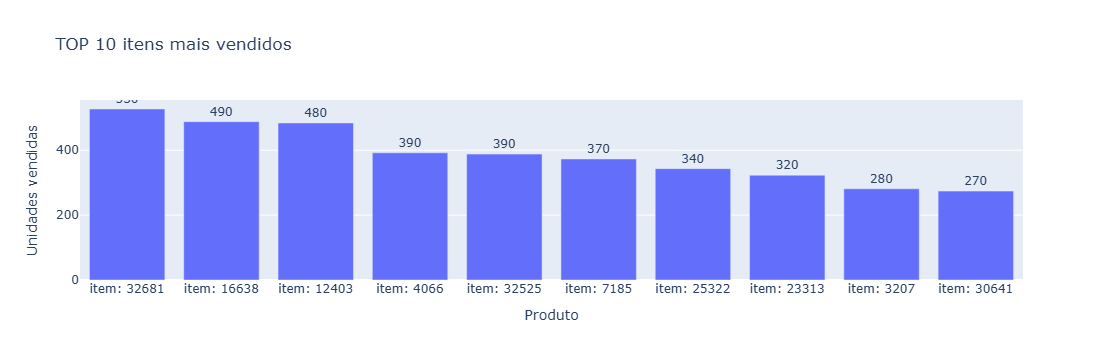

Sucesso: Gráfico salvo em '../visualizations/grafico_top10_itens_mais_vendidos.png'


In [2]:
consulta = """
select 'item: ' || dp.product_sk as produto
     , count(fs.sale_sk)         as total_unidades_vendidas
  from fact_sales  fs
  join dim_product dp on fs.product_sk = dp.product_sk
 group by dp.product_sk
 order by total_unidades_vendidas desc
 limit 10;
"""
df = pd.read_sql(sql=text(consulta), con=cn.get_engine())
print(df.head())

gg.gerar_grafico_sql( codigo_sql         = consulta
                    , coluna_x           = 'produto'
                    , coluna_y           = 'total_unidades_vendidas'
                    , rotulo_valor       = 'Unidades vendidas'
                    , titulo_grafico     = 'TOP 10 itens mais vendidos'
                    , tipo_grafico       = 'Barras'
                    , nome_arquivo_saida = '../visualizations/grafico_top10_itens_mais_vendidos.png'
                    , conexao            =  cn.get_engine()
                     )

-----------------
Esta consulta retorna o **histórico mensal de faturamento total**, calculado pela soma do preço dos itens e do valor do frete registrados na tabela de vendas (`fact_sales`), agrupados e formatados por ano e mês (ex: '2018-01') através da relação com a dimensão de tempo (`dim_date`), com os resultados exibidos em ordem cronológica para facilitar a análise da evolução das vendas ao longo do tempo.

   ano_mes  total_vendas
0  2016-09        354.75
1  2016-10      56808.84
2  2016-12         19.62
3  2017-01     137188.49
4  2017-02     286280.62


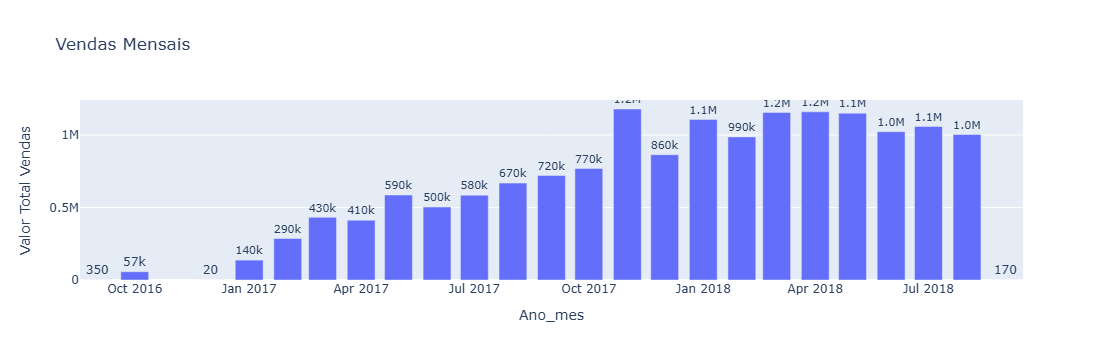

Sucesso: Gráfico salvo em '../visualizations/grafico_vendas_mensais.png'


In [3]:
consulta = """
select to_char(dd.full_date, 'yyyy-mm') as ano_mes
     , sum(fs.price + fs.freight_value) as total_vendas
  from fact_sales fs
  join dim_date   dd on fs.date_sk = dd.date_sk
 group by to_char(dd.full_date, 'yyyy-mm')
 order by ano_mes;
"""
df = pd.read_sql(sql=text(consulta), con=cn.get_engine())
print(df.head())

gg.gerar_grafico_sql( codigo_sql         = consulta
                    , coluna_x           = 'ano_mes'
                    , coluna_y           = 'total_vendas'
                    , rotulo_valor       = 'Valor Total Vendas'
                    , titulo_grafico     = 'Vendas Mensais'
                    , tipo_grafico       = 'Barras'
                    , nome_arquivo_saida = '../visualizations/grafico_vendas_mensais.png'
                    , conexao            =  cn.get_engine()
                     )

---
Esta consulta retorna um **ranking dos 10 clientes com maior volume financeiro de compras**, exibindo na primeira coluna a identificação do cliente formatada com o prefixo "client: " concatenado à sua chave (`customer_sk`) e na segunda coluna o somatório total do valor dos produtos mais o frete gastos por cada um, ordenados de forma decrescente para destacar os maiores consumidores da base.

In [4]:
consulta = """
select 'client: ' || dc.customer_sk     as cliente
     , sum(fs.price + fs.freight_value) as valor_total_compras
  from fact_sales fs
  join dim_customer dc on fs.customer_sk = dc.customer_sk
 group by dc.customer_sk
 order by valor_total_compras desc
 limit 10;
"""
df = pd.read_sql(sql=text(consulta), con=cn.get_engine())
print(df.head())

gg.gerar_grafico_sql( codigo_sql         = consulta
                    , coluna_x           = 'cliente'
                    , coluna_y           = 'valor_total_compras'
                    , rotulo_valor       = 'Valor Total Compras'
                    , titulo_grafico     = 'Top 10 Clientes que mais compram'
                    , tipo_grafico       = 'Barras'
                    , nome_arquivo_saida = '../visualizations/grafico_top10_clientes.png'
                    , conexao            =  cn.get_engine()
                     )

         cliente  valor_total_compras
0  client: 19411             13664.08
1  client: 75867              7274.88
2  client: 13175              6929.31
3   client: 1764              6922.21
4  client: 11348              6726.66


Sucesso: Gráfico salvo em '../visualizations/grafico_top10_clientes.png'


---
Esta consulta retorna um **relatório mensal de eficiência logística e volume de vendas**, agrupando os dados por Ano e Mês da compra. Para cada mês, ela exibe duas métricas principais: a **quantidade total de pedidos realizados** (`total_compras`) e o **tempo médio de entrega em dias** (`dias_medios_atendimento`) entre a compra e o recebimento pelo cliente, considerando apenas os pedidos que foram efetivamente entregues (`status 'delivered'`), ordenados cronologicamente.

Basicamente, ela responde à pergunta: **"Como o volume de vendas e a agilidade da minha entrega evoluíram mês a mês?"**

In [5]:
consulta = """
select to_char(df.order_purchase_timestamp::timestamp, 'yyyy-mm') as ano_mes
     , count(df.order_id) as total_compras
     , avg(extract(epoch from (df.order_delivered_customer_date::timestamp - df.order_purchase_timestamp::timestamp)) / 86400) as dias_medios_atendimento
  from df_orders df
 where df.order_status = 'delivered'
   and df.order_delivered_customer_date is not null
 group by to_char(df.order_purchase_timestamp::timestamp, 'yyyy-mm')
 order by ano_mes;
"""
df = pd.read_sql(sql=text(consulta), con=cn.get_engine())
print(df.head())

gg.gerar_grafico_sql( codigo_sql         = consulta
                    , coluna_x           = 'ano_mes'
                    , coluna_y           = 'dias_medios_atendimento'
                    , rotulo_valor       = 'Tempo Médio Atendimento'
                    , titulo_grafico     = 'Tempo médio do atendimento de pedidos'
                    , tipo_grafico       = 'Linha'
                    , nome_arquivo_saida = '../visualizations/grafico_tempo_medio_atendimento.png'
                    , conexao            =  cn.get_engine()
                     )

   ano_mes  total_compras  dias_medios_atendimento
0  2016-09              1                54.813194
1  2016-10            265                19.600559
2  2016-12              1                 4.693021
3  2017-01            750                12.647044
4  2017-02           1653                13.168825


Sucesso: Gráfico salvo em '../visualizations/grafico_tempo_medio_atendimento.png'


---
Esta consulta gera um **relatório de desempenho extremo dos 10 produtos mais vendidos** globalmente, exibindo para cada um deles (identificado pelo prefixo "item: " seguido de seu código) uma comparação lado a lado entre o **melhor mês de vendas** (data e quantidade máxima) e o **pior mês de vendas** (data e quantidade mínima), permitindo assim analisar a volatilidade, sazonalidade e os limites de demanda dos principais itens do portfólio.

       produto melhor_mes  qtd_vendas_max pior_mes  qtd_vendas_min
0   item: 3207    2017-07              29  2018-08               2
1   item: 4066    2017-11              87  2017-06               3
2   item: 7185    2017-11              82  2017-04               3
3  item: 12403    2017-11              91  2017-06               1
4  item: 16638    2017-07              60  2017-02               2


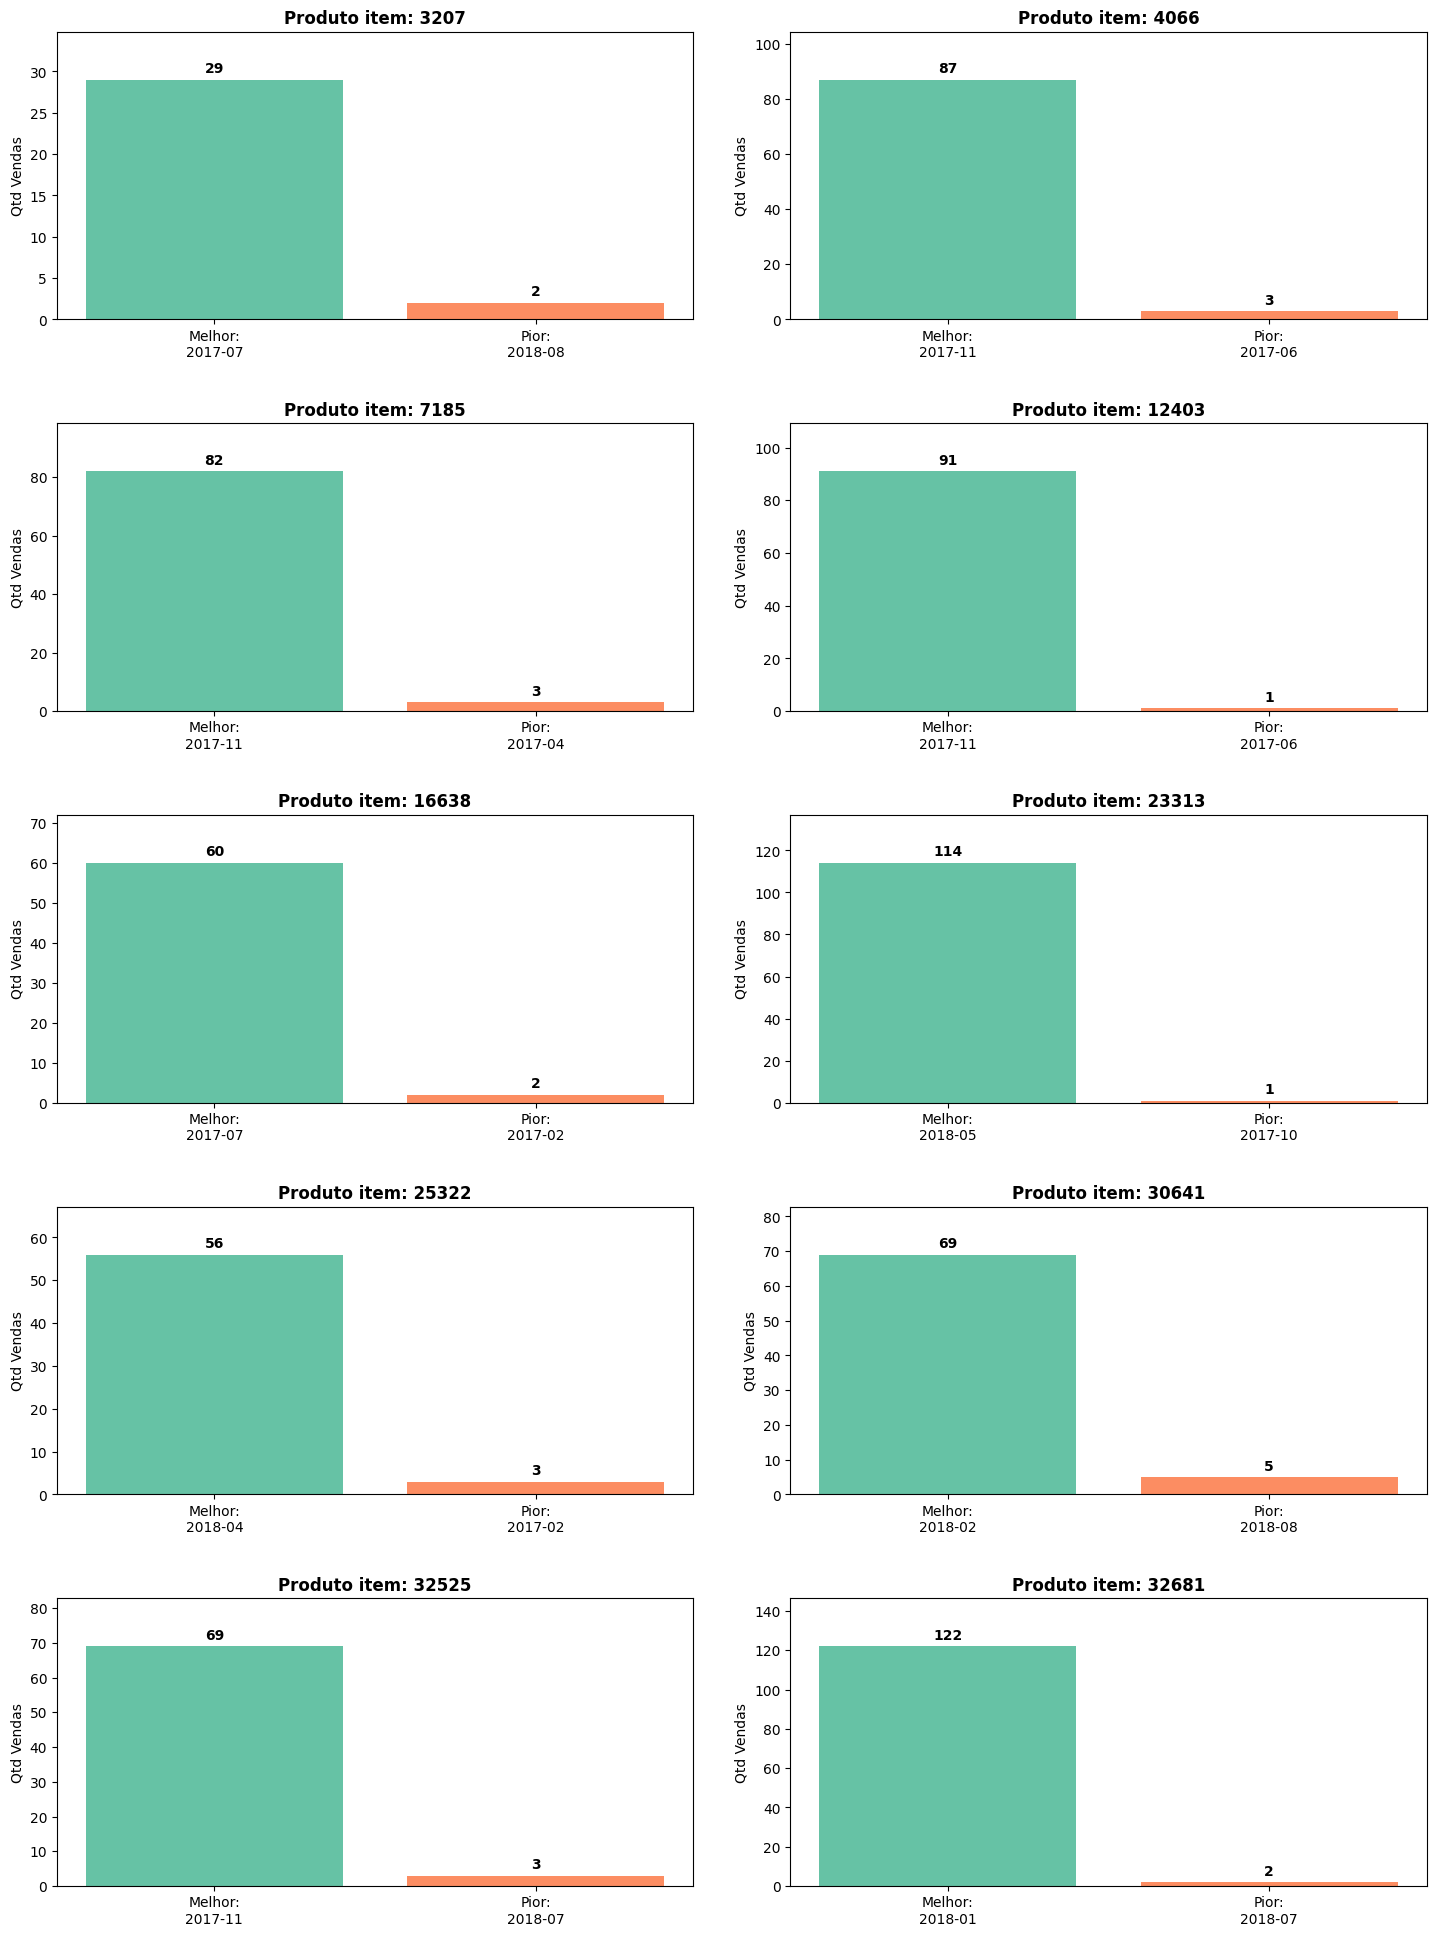

Gráfico salvo com sucesso em: ../visualizations/grafico_melhor-e-pior-desempenho_itens.png


In [6]:
consulta = """
-- 1. calcula o total de vendas por produto e por mês
with vendas_mensais
  as ( select dp.product_id
            , to_char(dd.full_date, 'yyyy-mm') as ano_mes
            , count(fs.sale_sk) as qtd_vendas
         from fact_sales  fs
         join dim_product dp on fs.product_sk = dp.product_sk
         join dim_date    dd on fs.date_sk    = dd.date_sk
        group by dp.product_id
               , to_char(dd.full_date, 'yyyy-mm')
      )

-- 2. descobre quem são os top 10 no total geral
   , top_10_produtos
  as ( select product_id
         from vendas_mensais
        group by product_id
        order by sum(qtd_vendas) desc
        limit 10
      )

-- 3. para os top 10, cria um ranking dos meses (do melhor para o pior e vice-versa)
   , ranking_meses
 as ( select vm.product_id
           , vm.ano_mes
		   , vm.qtd_vendas
		   , row_number() over (partition by vm.product_id order by vm.qtd_vendas desc) as rank_max -- rank 1 será o mês com maior venda
		   , row_number() over (partition by vm.product_id order by vm.qtd_vendas asc) as rank_min  -- rank 1 será o mês com menor venda
        from vendas_mensais vm
       inner join top_10_produtos tp on vm.product_id = tp.product_id
     )

-- 4. pivota o resultado para mostrar tudo em uma linha por produto
select 'item: '|| product_sk as produto
     , max(case when rank_max = 1 then ano_mes end)    as melhor_mes
	 , max(case when rank_max = 1 then qtd_vendas end) as qtd_vendas_max
	 , max(case when rank_min = 1 then ano_mes end)    as pior_mes
	 , max(case when rank_min = 1 then qtd_vendas end) as qtd_vendas_min
  from ranking_meses rm
  join dim_product   dp on dp.product_id = rm.product_id
 where rank_max = 1 or rank_min = 1
 group by product_sk;
"""
df = pd.read_sql(sql=text(consulta), con=cn.get_engine())
print(df.head())

gg.plotar_comparacao_produtos(df=df, arquivo_saida='../visualizations/grafico_melhor-e-pior-desempenho_itens.png')

✅ Dashboard consolidado salvo com sucesso em: ..\visualizations\dashboard_consolidado.png


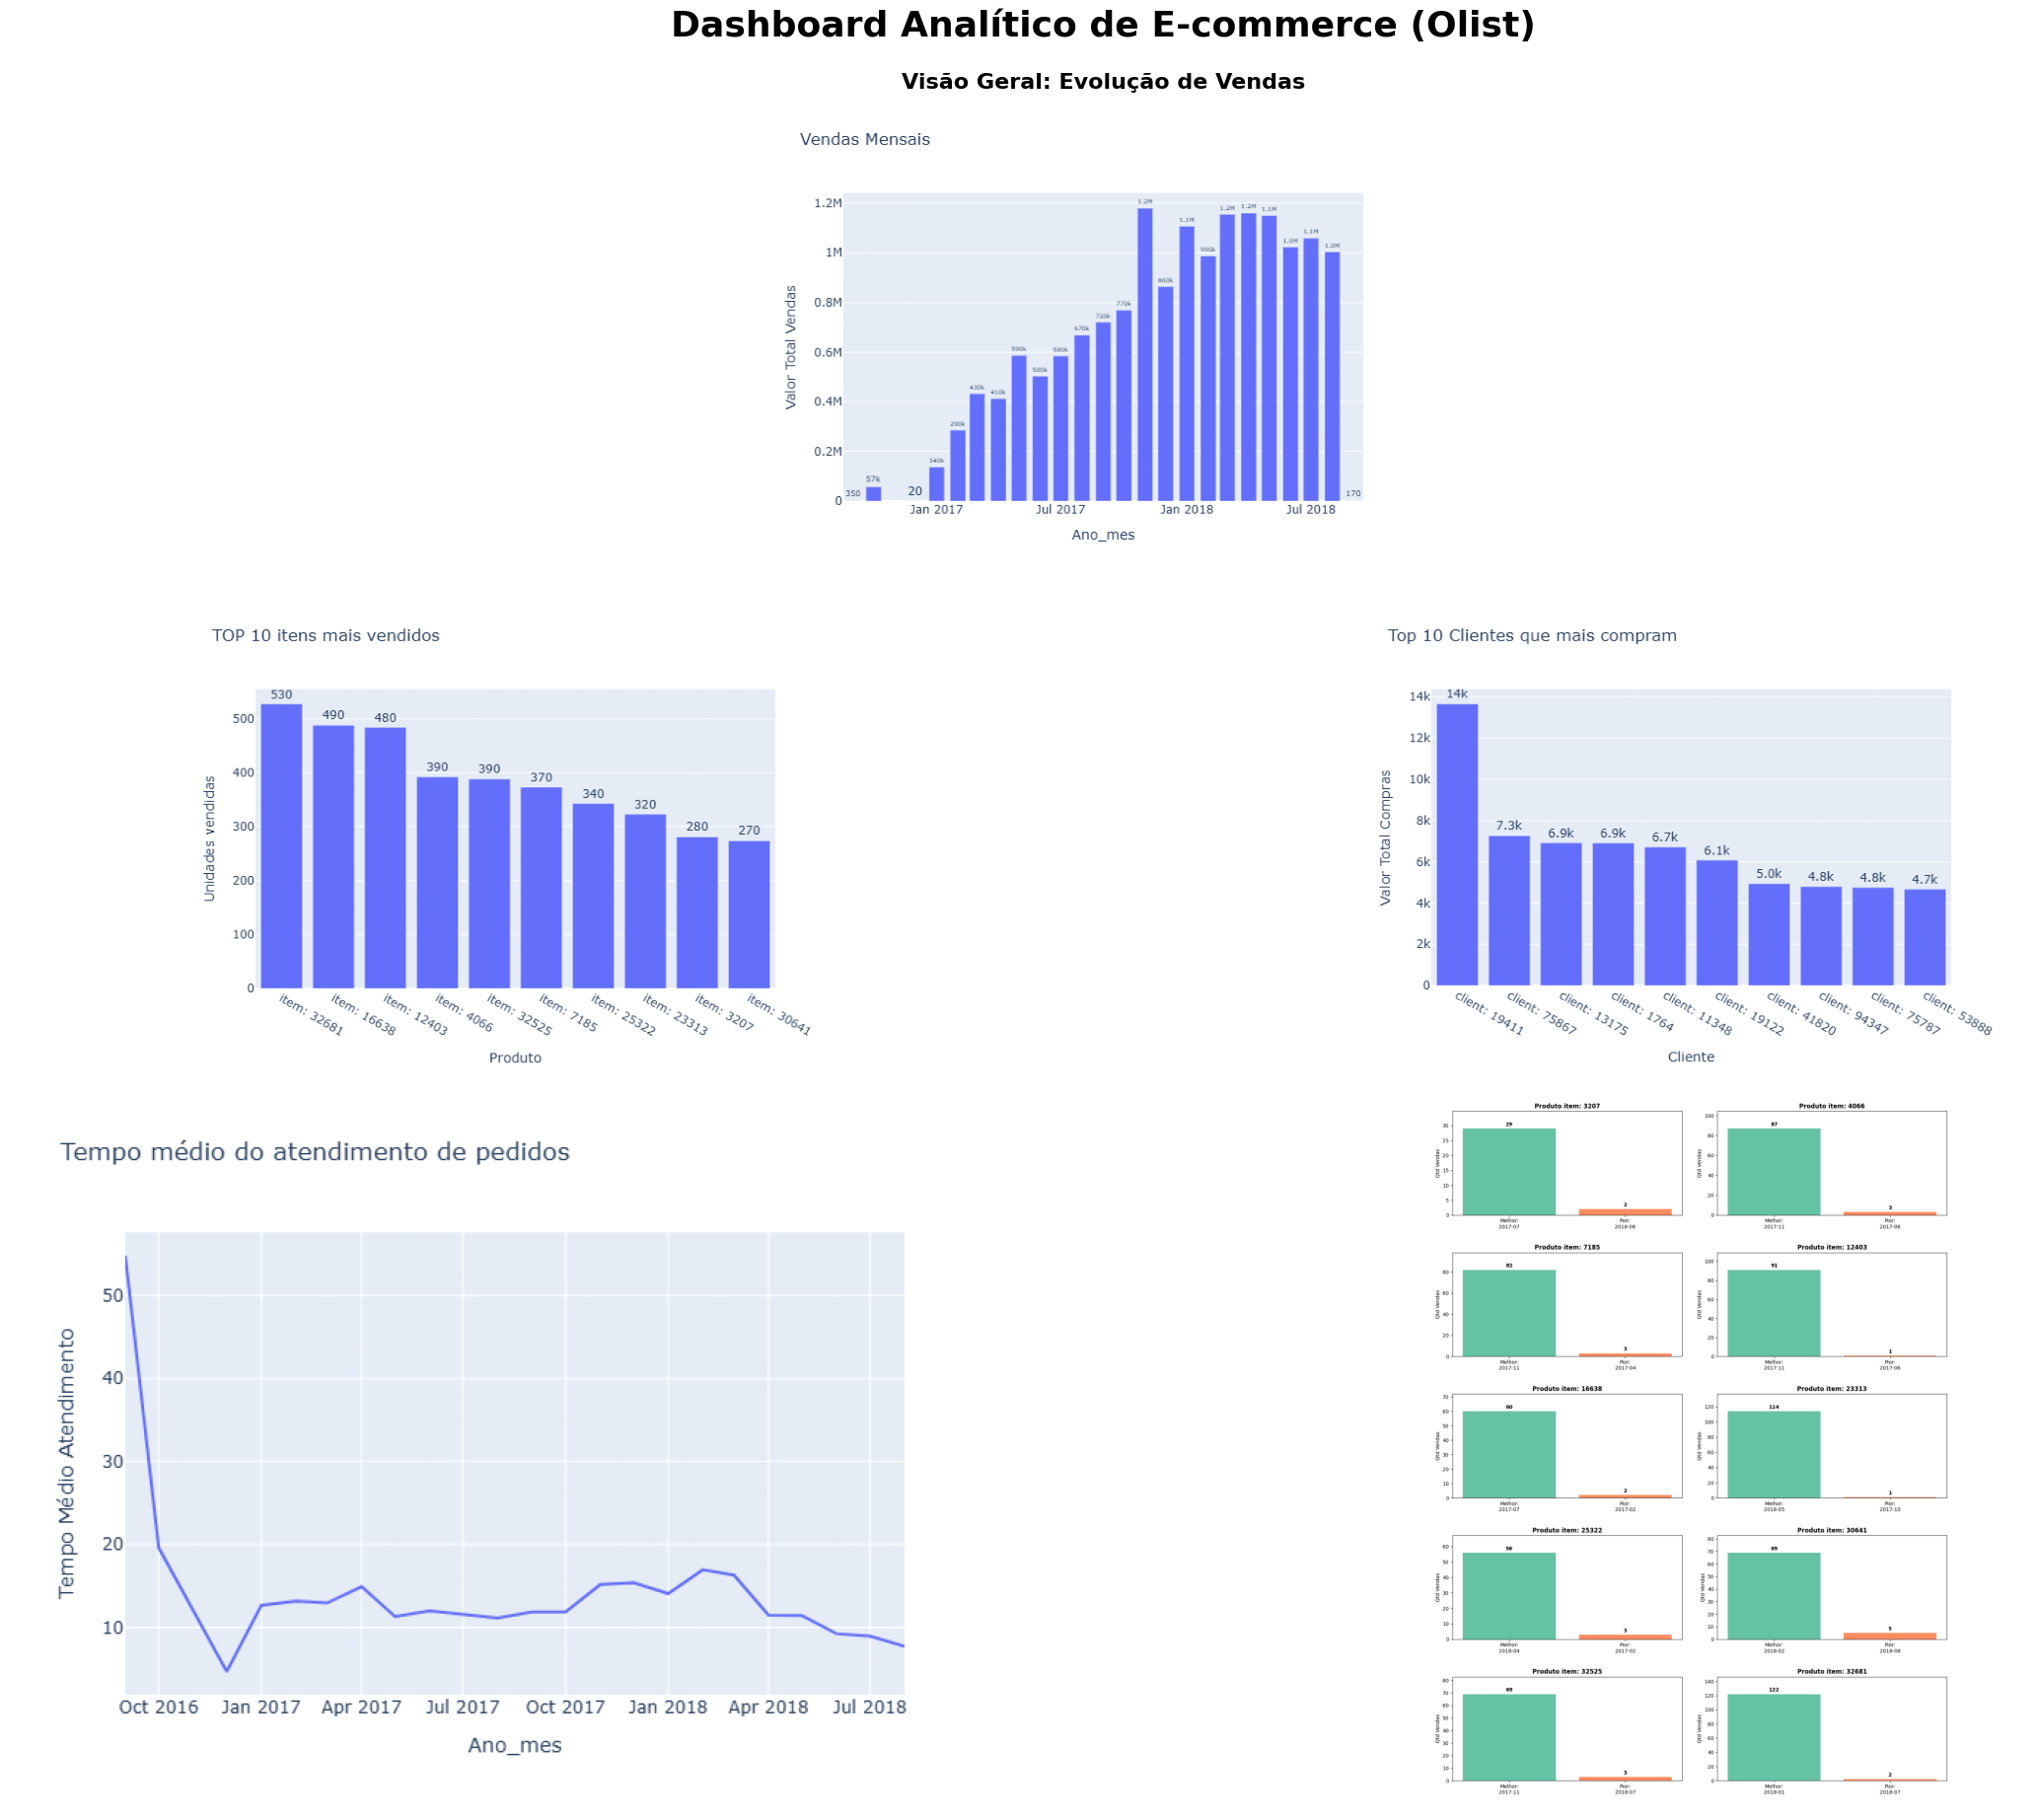

In [3]:
# Gera o Dashboard
# Ele vai procurar os PNGs na pasta 'visualizations' e salvar o resultado lá também
gg.gerar_dashboard_consolidado(
    pasta_origem='../visualizations', 
    nome_arquivo_saida='dashboard_consolidado.png')